In [1]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.optimize
import pandas as pd
from IPython.display import Audio
import csv

In [2]:
def get_envelope(t, x, d=1):
    def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
        """
        Input :
        s: 1d-array, data signal from which to extract high and low envelopes
        dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
        split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
        Output :
        lmin,lmax : high/low envelope idx of input signal s
        """

        # locals min
        lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
        # locals max
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

        if split:
            # s_mid is zero if s centered around x-axis or more generally mean of signal
            s_mid = np.mean(s)
            # pre-sorting of locals min based on relative position with respect to s_mid
            lmin = lmin[s[lmin] < s_mid]
            # pre-sorting of local max based on relative position with respect to s_mid
            lmax = lmax[s[lmax] > s_mid]

        # global min of dmin-chunks of locals min
        lmin = lmin[
            [i + np.argmin(s[lmin[i : i + dmin]]) for i in range(0, len(lmin), dmin)]
        ]
        # global max of dmax-chunks of locals max
        lmax = lmax[
            [i + np.argmax(s[lmax[i : i + dmax]]) for i in range(0, len(lmax), dmax)]
        ]

        return lmin, lmax

    _, lmax = hl_envelopes_idx(x, dmax=d)
    lmax = np.interp(t, t[lmax], x[lmax])
    return lmax

def nextpow2(N):
    n = 1
    while n < N:
        n *= 2
    return n

le signal commence à 0.047875 s
niveau de silence: -10.00 dB (0.32 V)
le signal finit à 0.347875
104.76190476190476 115.5
156.19047619047618 172.20000000000002
204.76190476190476 225.75
220.95238095238093 243.60000000000002
231.42857142857142 255.15
257.1428571428571 283.5


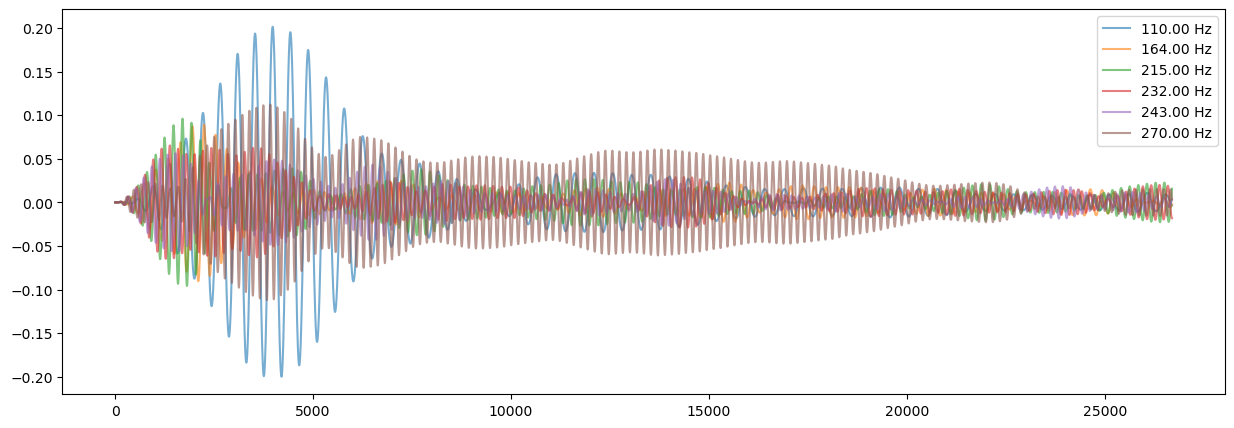

In [25]:
f1s = [66, 91, 111, 127]
ensembles = ["grave", "migrave", "miaigu", "aigu"]
ensembles=ensembles[0:1]
for f1, ensemble in zip(f1s, ensembles):
    sigs = []

    filename = f"timbale-{ensemble}-1.wav"
    fs, sig = scipy.io.wavfile.read(filename)
    sig = sig.astype(np.float32)
    sig /= np.max(abs(sig))
    t = np.arange(len(sig)) / fs
    env = get_envelope(t, sig)

    MARGE_START_BEFORE = int(0.01 * fs)
    MARGE_START_AFTER = int(0.1 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SILENCE = -0.01

    i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
    print(f"le signal commence à {i_silence/fs} s")
    silence_level = np.max(abs(sig[:i_silence]))
    print(
        f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
    )

    t = np.arange(len(sig)) / fs
    i_start = i_silence + MARGE_START_AFTER

    i_searchend = i_start + MARGE_SEARCH_END
    i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
    print("le signal finit à", i_end / fs)
    
    sig = sig[i_silence:]

    N = 8*nextpow2(len(sig))

    f_partiels = [110,	164,	215,	232,	243,	270]
    alpha = 1.05
    plt.figure(figsize=(15,5))
    for f_p in f_partiels:
        print(f_p/alpha, f_p*alpha)
        sos = scipy.signal.butter(3, [f_p/alpha, f_p*alpha], btype="bandpass", fs=fs, output="sos")
        filtered = scipy.signal.sosfilt(sos, sig)
        plt.plot(filtered[:i_end+10000], label=f"{f_p:.2f} Hz", alpha=0.6)
    plt.legend()
    plt.show()



/tmp/ipykernel_41690/2394068904.py:3: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(w,20*np.log(h))
/tmp/ipykernel_41690/2394068904.py:3: RuntimeWarning: invalid value encountered in multiply
  plt.semilogx(w,20*np.log(h))
/usr/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


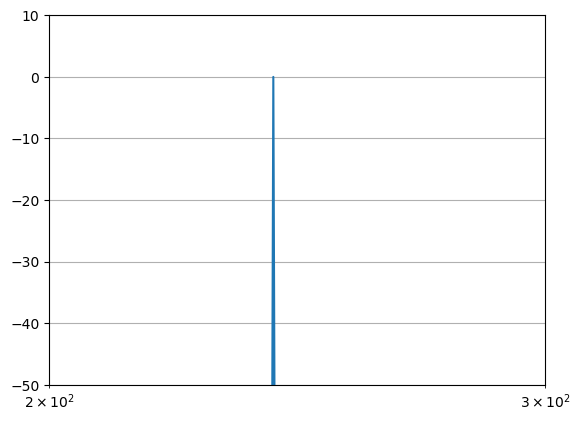

In [4]:
sos = scipy.signal.butter(20, [240,241], btype="bandpass", fs=48000, output="sos")
w,h = scipy.signal.sosfreqz(sos, 8*1024, fs=48000)
plt.semilogx(w,20*np.log(h))
plt.ylim(-50,10)
plt.xlim(200,300)
plt.grid()